# **WQU Capstone Project**

### **Dynamic MACD Trading with Multi-modal Agent**

#### **Student Group 6386**
##### Sunil Sharma ([sunilksh+mscfe@outlook.com](mailto:sunilksh+mscfe@outlook.com))

---

<br>

# Objective

The purpose of this notebook is to observe/analyse different LLM vision models (including GPT-4v, LLava etc), in their capability to interpret the technical indicators especially, Moving Average Convergence Divergence (MACD). This notebook serves as an intermediate step, where the model interpretations will be used to assess the specific Vision model's potential with AI agents for automating and optimizing the trading strategies.

## Dataset Details

The dataset used in this analysis contains the historical stock prices of Indian stocks. The data includes the following columns:
- **symbol**: Stock ticker symbol (YESBANK in our case).
- **date**: Trading date.
- **open**: Opening price of the stock on given date.
- **high**: Highest price of the stock on given date.
- **low**: Lowest price of the stock on given date.
- **close**: Closing price of the stock on given date.
- **volume**: Trading volume of the stock on given date.

### Data Source:
The data is loaded from a CSV file and filtered to include only the last year’s data for analysis in this notebook.

The financial plots are created using mplfinance python library (https://github.com/matplotlib/mplfinance)

CONFIG.json is a json file having configuration of the models(model name and api_key) to be tested:

    {
        "model": "model1",
        "api_key": "sk-proj-key1"
    },
    {
        "model": "model2",
        "api_key": "sk-proj-key2"
    },


## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import json
from datetime import datetime, timedelta

# Using the OpenAI API for GPT-4v model.
import openai
from openai import OpenAI

# Using the  matplotlib finance API to create financial plots.
import mplfinance as mpf

In [2]:
# Define the stock symbol
stock_symbol = 'YESBANK'  

## Load Data

In [3]:

# Fetch historical data for YESBANK
data = pd.read_csv(f'..\..\data\DailyData\{stock_symbol}.csv')

In [4]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Filter data for the last year
one_year_ago = datetime.now() - timedelta(days=365)
data = data[data.index >= one_year_ago]

# Ensure the index is sorted
data.sort_index(inplace=True)

In [5]:
# Display the first few rows to verify
print(data.head()) 
print(data.info())

             symbol   open   high    low  close     volume
date                                                      
2023-07-12  YESBANK  17.20  17.65  17.15  17.30  130780311
2023-07-13  YESBANK  17.40  17.75  17.05  17.15  125488345
2023-07-14  YESBANK  17.25  17.45  17.15  17.35   84681372
2023-07-17  YESBANK  17.50  17.85  17.45  17.70  172530429
2023-07-18  YESBANK  17.70  17.90  17.35  17.50  165908743
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 198 entries, 2023-07-12 to 2024-04-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  198 non-null    object 
 1   open    198 non-null    float64
 2   high    198 non-null    float64
 3   low     198 non-null    float64
 4   close   198 non-null    float64
 5   volume  198 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 10.8+ KB
None


## Calculate EMAs, MACD, and Signal Line

In [6]:
# Calculate EMAs
ema_fast = data['close'].ewm(span=12, adjust=False).mean()
ema_slow = data['close'].ewm(span=26, adjust=False).mean()

# Calculate MACD, Signal and Histogram
macd = ema_fast - ema_slow
signal = macd.ewm(span=9, adjust=False).mean()
histogram = macd - signal

## Plot the Data with mplfinance

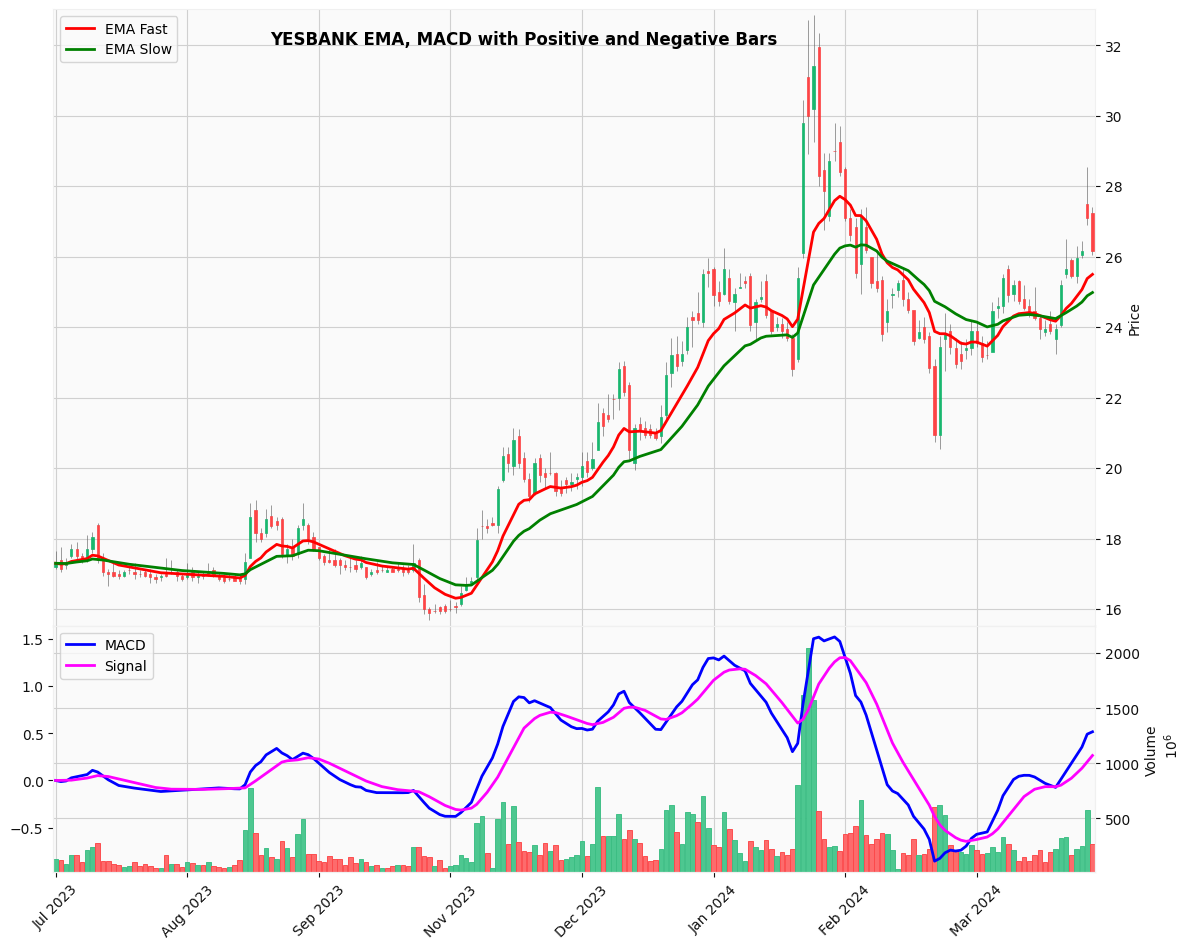

In [7]:
import matplotlib.dates as mdates

# Prepare data for mplfinance
ema_fast_plot = mpf.make_addplot(ema_fast, color='red', width=2.0, secondary_y=False)
ema_slow_plot = mpf.make_addplot(ema_slow, color='green', width=2.0, secondary_y=False)

# Split histogram into positive and negative values
histogram_positive = histogram.where(histogram >= 0)
histogram_negative = histogram.where(histogram < 0)

# Plot the data
histogram_positive_plot = mpf.make_addplot(histogram_positive, panel=1, type='bar', color='green', secondary_y=False, width=0.8)
histogram_negative_plot = mpf.make_addplot(histogram_negative, panel=1, type='bar', color='red', secondary_y=False, width=0.8)
macd_plot = mpf.make_addplot(macd, panel=1, color='blue', width=2.0, secondary_y=True)
signal_plot = mpf.make_addplot(signal, panel=1, color='magenta', width=2.0, secondary_y=True)
apds = [ema_fast_plot, ema_slow_plot, histogram_positive_plot, histogram_negative_plot, macd_plot, signal_plot]
style = mpf.make_mpf_style(base_mpf_style='yahoo', mavcolors=['red', 'green'])

kwargs = dict(
    type='candle', 
    addplot=apds, 
    volume=True, 
    title=f'YESBANK EMA, MACD with Positive and Negative Bars',
    ylabel='Price',
    ylabel_lower='Volume',
    tight_layout=True,
    style=style,
    figsize=(12,10),
    datetime_format='%b %Y',  # Set the datetime format to month-year
)

fig, axlist = mpf.plot(data, **kwargs, returnfig=True)

# Adjust the layout to prevent overlap
fig.subplots_adjust(top=0.9)

# Set title with specific location
fig.suptitle('YESBANK EMA, MACD with Positive and Negative Bars', y=0.95, fontsize=12)

# Add legend
legend_lines = [
    axlist[0].plot([], [], color='red', linewidth=2, label='EMA Fast')[0],
    axlist[0].plot([], [], color='green', linewidth=2, label='EMA Slow')[0],
    axlist[2].plot([], [], color='blue', linewidth=2, label='MACD')[0],
    axlist[2].plot([], [], color='magenta', linewidth=2, label='Signal')[0],
]
axlist[0].legend(handles=legend_lines[:2], loc='upper left')
axlist[2].legend(handles=legend_lines[2:], loc='upper left')

# Show the plot
plt.show()

## Use GPT-4V and Other Vision Models for Interpretation

In [8]:
# Load OpenAI configuration from the JSON file
with open('config.json', 'r') as file:
    config_list = json.load(file)

# Loading a specific model configuration
def load_config(model_name):
    for config in config_list:
        if config['model'] == model_name:
            return config
    raise ValueError(f"Model {model_name} not found in config file")

In [9]:
# Plot and encode the chart
def plot_and_encode(fig):
    buf = BytesIO()
    fig.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    encoded_image = base64.b64encode(buf.read()).decode('utf-8')
    return encoded_image

encoded_image = plot_and_encode(fig)

In [ ]:
prompt = f"""
Please analyze the attached chart which shows the following:
1. Candlestick plot of {stock_symbol} stock price over one year.
2. Two Exponential Moving Averages (EMA):
    - EMA Fast (red)
    - EMA Slow (green)
3. MACD (blue line) and Signal (magenta line) plotted on the lower panel.
4. MACD Histogram with positive (green bars) and negative (red bars) values.

Could you provide insights on the following aspects?
1. Identify the periods of bullish and bearish trends based on the EMAs.
2. Highlight the points/periods where the MACD line crosses the Signal line and interpret their significance.
"""

### GPT-4V

In [ ]:
# GPT-4 model configuration
model_name = 'gpt-4o'
config = load_config(model_name)

# Set the OpenAI API key and model
api_key = config['api_key']
model = config['model']
openai.api_key = api_key

client = OpenAI(api_key=api_key)

response = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_image}"}}
            ]
        }
    ],
    # Number of tokens for GPT-4 model
    max_tokens=600,
    temperature=0, # Added for more deterministic results
)

In [ ]:
print(response.choices[0].message.content)

### Analysis of YESBANK Stock Chart

#### 1. Identifying Bullish and Bearish Trends Based on EMAs

- **Bullish Trends**: 
  - A bullish trend is indicated when the EMA Fast (red line) crosses above the EMA Slow (green line) and stays above it. 
  - Notable periods of bullish trends:
    - Early August 2023 to mid-September 2023: The EMA Fast crosses above the EMA Slow and remains above it.
    - Early November 2023 to mid-February 2024: The EMA Fast is consistently above the EMA Slow, indicating a strong upward trend.
    - Early March 2024 to early April 2024: The EMA Fast crosses above the EMA Slow again, suggesting a potential bullish trend.

- **Bearish Trends**: 
  - A bearish trend is indicated when the EMA Fast crosses below the EMA Slow and stays below it.
  - Notable periods of bearish trends:
    - Mid-September 2023 to early November 2023: The EMA Fast crosses below the EMA Slow and remains below it.
    - Mid-February 2024 to early March 2024: The EMA Fast crosses below the

# LlaVa 

In [78]:
# LlaVa model configuration
model_name = 'xtuner/llava-llama-3-8b-v1_1-gguf/llava-llama-3-8b-v1_1-int4.gguf:0'
config = load_config(model_name)
print(config)
# Set the OpenAI API key and model
api_key = config['api_key']
model = config['model']
base_url = config['base_url']

client = OpenAI(base_url=base_url, api_key=api_key)

response = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_image}"}}
            ]
        }
    ],
    # Number of tokens for LlaVa model
    max_tokens=600,
    temperature=0, # More deterministic results

)

{'model': 'xtuner/llava-llama-3-8b-v1_1-gguf/llava-llama-3-8b-v1_1-int4.gguf:0', 'base_url': 'http://localhost:1234/v1', 'api_key': 'not-needed'}


In [46]:
print(response.choices[0].message.content)

The image presents a detailed analysis of the stock price of YEGANKE, specifically focusing on its performance over one year. The chart is divided into two panels, each representing different aspects of the stock's behavior.

In the upper panel, we see the candlestick plot of the stock price. This type of chart is used to visually represent the opening and closing prices of a security over time. In this case, the stock price is depicted in blue, with the MACD line in orange and the Signal line in magenta. These lines are important indicators for identifying trends and potential buying or selling opportunities.

The lower panel provides a more detailed view of the stock's performance. It shows the MACD histogram, which is a graphical representation of the difference between two moving averages. The histogram is colored in green and red, indicating positive and negative values respectively. This color-coding helps to quickly identify periods of bullish and bearish trends.

The chart also

# BakLlaVa 

In [75]:
# BakLLaVA model's configuration
model_name = 'abetlen/BakLLaVA-1-GGUF:0'
config = load_config(model_name)
print(config)
# Set the OpenAI API key and model
api_key = config['api_key']
model = config['model']
base_url = config['base_url']

client = OpenAI(base_url=base_url, api_key=api_key)

response = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_image}"}}
            ]
        }
    ],
    # Number of tokens for BakLLaVA model
    max_tokens=600,
    temperature=0, # More deterministic results
)

{'model': 'abetlen/BakLLaVA-1-GGUF:0', 'base_url': 'http://localhost:1234/v1', 'api_key': 'not-needed'}


In [77]:
print(response.choices[0].message.content)


The image shows a chart with a stock price (YESBANK) and an exponential moving average (EMA). The EMA is plotted above the stock price, and they both appear to be trending upwards. This suggests that the stock has been performing well and may continue to rise in the future. Additionally, there are other financial indicators plotted on the chart, which can help analyze the stock's performance and make informed decisions about investing or trading.


The notebook looked at how well three different vision modelsᅳGPT-4V, LLava, and BakLlaVaᅳcan read and interpret the MACD indicator for stock trading. GPT-4V came out on top, doing the best job of spotting bullish and bearish trends and correctly identifying when the MACD lines crossed. This makes it very reliable for financial analysis. LLava was also pretty good but not as precise as GPT-4V. BakLlaVa worked but wasn't as accurate at detecting trend reversals and signal crossings, suggesting it needs some more work. Overall, GPT-4V was the most dependable model for getting insights based on MACD.